**CS 189 Homework 1**

First, ensure all the data can be loaded. The code uses relative path, so make sure you have cd'ed into scripts for this relative path to work

In [41]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io

if __name__ == "__main__":
    for data_name in ["toy", "mnist", "spam"]:
        data = np.load(f"../data/{data_name}-data.npz") # Make sure you have cd'ed into scripts for this relative path to work
        print("\nloaded %s data!" % data_name)
        fields = "training_data", "training_labels", "test_data"
        for field in fields:
            print(field, data[field].shape)


loaded toy data!
training_data (1000, 2)
training_labels (1000,)
test_data (0,)

loaded mnist data!
training_data (60000, 1, 28, 28)
training_labels (60000,)
test_data (10000, 1, 28, 28)

loaded spam data!
training_data (4171, 34)
training_labels (4171,)
test_data (1000, 34)


**Data Partitioning and Evaluation Metrics**

Shuffle an index at random and use that to index to allocate the training data, training labels, validation data, and validation labels.

In [43]:
import numpy as np

def shuffle_and_partition(data, labels, validation_size):

    # Shuffle data and set a seed for reproducibility
    np.random.seed(42) 
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    # Apply the shuffled indices
    shuffled_data = data[indices]
    shuffled_labels = labels[indices]

    # Partition into training and validation sets
    val_data = shuffled_data[:validation_size]
    val_labels = shuffled_labels[:validation_size]
    train_data = shuffled_data[validation_size:]
    train_labels = shuffled_labels[validation_size:]

    return train_data, train_labels, val_data, val_labels

# For the MNIST dataset partitioning, set aside 10,000 images for validation
data_mnist = np.load(f"../data/mnist-data.npz")
training_data_mnist = data_mnist["training_data"].reshape(-1, 28 * 28)  # Flatten images
# training_data_mnist = data_mnist["training_data"]
labels_mnist = data_mnist["training_labels"]
mnist_train_data, mnist_train_labels, mnist_val_data, mnist_val_labels = shuffle_and_partition(
    training_data_mnist, labels_mnist, validation_size=10000
)

# For the Spam dataset partitioning, set aside 20% of the data for validation
data_spam = np.load(f"../data/spam-data.npz")
training_data_spam = data_spam["training_data"]
labels_spam = data_spam["training_labels"]
validation_size_spam = int(0.2 * training_data_spam.shape[0])
spam_train_data, spam_train_labels, spam_val_data, spam_val_labels = shuffle_and_partition(
    training_data_spam, labels_spam, validation_size=validation_size_spam
)

def classification_accuracy(y, y_hat):
    # y (numpy.ndarray): Ground-truth labels, shape (n,).
    # y_hat (numpy.ndarray): Predicted labels, shape (n,).
    assert y.shape == y_hat.shape, "Shapes are a mismatch"
    return np.sum(y == y_hat) / y.shape[0]



**Support Vector Machines: Coding**

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

def train_and_evaluate_svm(train_data, train_labels, val_data, val_labels, training_sizes):
    training_accuracies = []
    validation_accuracies = []

    for size in training_sizes: # Repeat the following steps for all training sizes

        # Use the specified numbers of training examples
        subset_data = train_data[:size]
        subset_labels = train_labels[:size]

        # Train the linear SVM
        svm = LinearSVC(max_iter=10000, random_state=42)
        svm.fit(subset_data, subset_labels)

        # Evaluate on training data
        train_predictions = svm.predict(subset_data)
        train_accuracy = classification_accuracy(subset_labels, train_predictions)
        training_accuracies.append(train_accuracy)

        # Evaluate on validation data
        val_predictions = svm.predict(val_data)
        val_accuracy = classification_accuracy(val_labels, val_predictions)
        validation_accuracies.append(val_accuracy)

    return {
        "training_accuracies": training_accuracies,
        "validation_accuracies": validation_accuracies
    }

/Users/michaelng/anaconda3/envs/cs189/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[np.float64(0.6958), np.float64(0.7603), np.float64(0.8055), np.float64(0.8185), np.float64(0.8232), np.float64(0.8112), np.float64(0.847)]


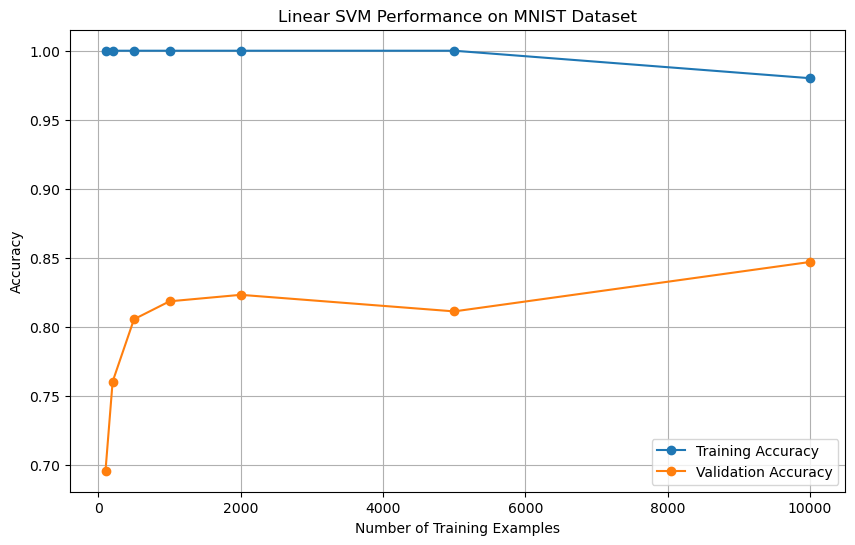

MNIST training data shape: (50000, 784)
MNIST validation data shape: (10000, 784)


In [45]:
# Train and evaluate SVM on MNIST
mnist_training_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]
mnist_svm_results = train_and_evaluate_svm(mnist_train_data, mnist_train_labels, mnist_val_data, mnist_val_labels, mnist_training_sizes)
print(mnist_svm_results["validation_accuracies"])

plt.figure(figsize=(10, 6))
plt.plot(mnist_training_sizes, mnist_svm_results["training_accuracies"], label="Training Accuracy", marker="o")
plt.plot(mnist_training_sizes, mnist_svm_results["validation_accuracies"], label="Validation Accuracy", marker="o")
plt.title("Linear SVM Performance on MNIST Dataset")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Outputs (for testing/debugging)
print("MNIST training data shape:", mnist_train_data.shape)
print("MNIST validation data shape:", mnist_val_data.shape)

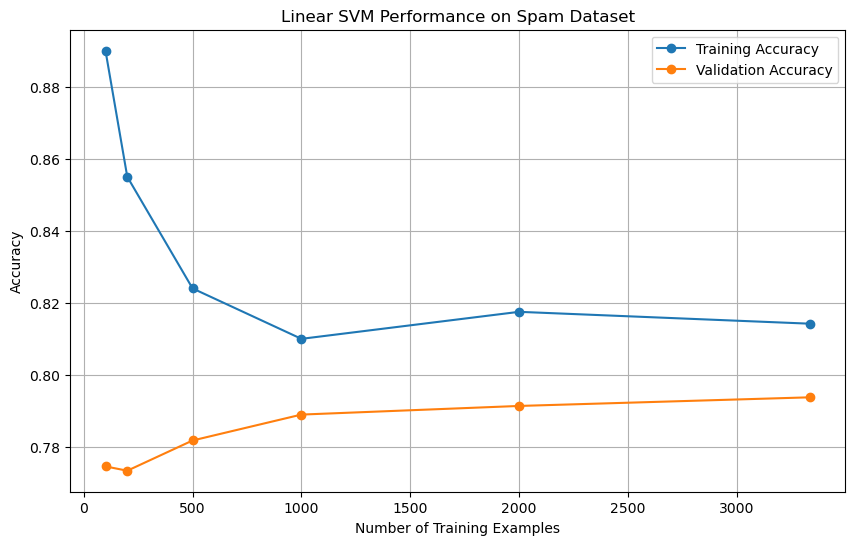

Spam training data shape: (3337, 32)
Spam validation data shape: (834, 32)


In [6]:
# Train and evaluate SVM on Spam
spam_training_sizes = [100, 200, 500, 1000, 2000, spam_train_data.shape[0]]
spam_svm_results = train_and_evaluate_svm(
    spam_train_data, spam_train_labels, spam_val_data, spam_val_labels, spam_training_sizes
)

plt.figure(figsize=(10, 6))
plt.plot(spam_training_sizes, spam_svm_results["training_accuracies"], label="Training Accuracy", marker="o")
plt.plot(spam_training_sizes, spam_svm_results["validation_accuracies"], label="Validation Accuracy", marker="o")
plt.title("Linear SVM Performance on Spam Dataset")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Outputs (for testing/debugging)
print("Spam training data shape:", spam_train_data.shape)
print("Spam validation data shape:", spam_val_data.shape)

**Hyperparameter Tuning**

In the previous problem, by training SVM models with varying amounts of training examples, we
learned parameters for a model that classifies the data. Many classifiers also have hyperparameters that we can tune to influence the parameters. In this problem, we’ll determine good values for the regularization parameter C in the soft-margin SVM algorithm. The interpretation of this parameter, as well as the functioning of the soft-margin SVM will be covered in lecture. For now, consider C as a parameter of a black-box algorithm that we aim to optimize.

MNIST Hyperparameter Sweep Results:
C: 0.0001, Validation Accuracy: 0.8680
C: 0.001, Validation Accuracy: 0.8530
C: 0.01, Validation Accuracy: 0.8498
C: 0.1, Validation Accuracy: 0.8484
C: 1, Validation Accuracy: 0.8470
C: 10, Validation Accuracy: 0.8480
C: 100, Validation Accuracy: 0.8483
C: 1000, Validation Accuracy: 0.8476
Best C: 0.0001, Best Validation Accuracy: 0.8680


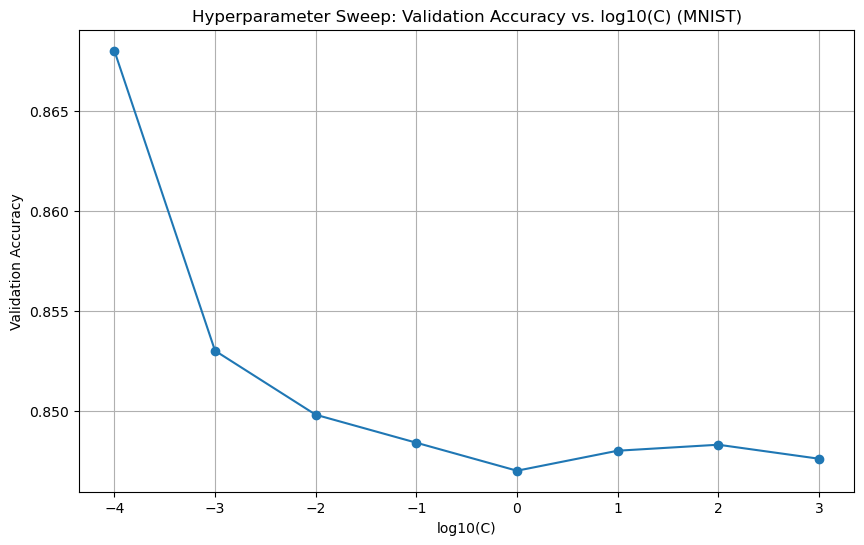

In [4]:
def hyperparameter_sweep(train_data, train_labels, val_data, val_labels, training_size, c_values):
    best_c = None
    best_val_accuracy = 0
    results = []

    # Use only the specified number of training examples
    subset_data = train_data[:training_size]
    subset_labels = train_labels[:training_size]

    for c in c_values:
        # Train the linear SVM with the current C value
        svm = LinearSVC(C=c, max_iter=10000, random_state=42)
        svm.fit(subset_data, subset_labels)

        # Evaluate on validation data
        val_predictions = svm.predict(val_data)
        val_accuracy = classification_accuracy(val_labels, val_predictions)
        results.append((c, val_accuracy))
        if val_accuracy > best_val_accuracy: # Update the best C value if current C performs better
            best_c = c
            best_val_accuracy = val_accuracy

    return {"best_c": best_c, "best_val_accuracy": best_val_accuracy, "results": results}

# Define hyperparameter C values to sweep
# In earlier iterations, I had included 10000 and 100000, but doing so would take up inordinate amounts of time (~61 minutes) so I have taken them out
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Perform hyperparameter sweep on MNIST
mnist_hyperparameter_results = hyperparameter_sweep(
    mnist_train_data, mnist_train_labels, mnist_val_data, mnist_val_labels, training_size=10000, c_values=c_values
)

# Output the results for MNIST
print("MNIST Hyperparameter Sweep Results:")
for c, acc in mnist_hyperparameter_results["results"]:
    print(f"C: {c}, Validation Accuracy: {acc:.4f}")
print(f"Best C: {mnist_hyperparameter_results['best_c']}, Best Validation Accuracy: {mnist_hyperparameter_results['best_val_accuracy']:.4f}")

# Plot validation accuracy for MNIST hyperparameter sweep
plt.figure(figsize=(10, 6))
c_log_values = np.log10(c_values)  # Log scale for better visualization
validation_accuracies = [acc for _, acc in mnist_hyperparameter_results["results"]]

plt.plot(c_log_values, validation_accuracies, marker="o")
plt.title("Hyperparameter Sweep: Validation Accuracy vs. log10(C) (MNIST)")
plt.xlabel("log10(C)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

**K-Fold Cross-Validation**

Spam 5-Fold Cross-Validation Results:
C: 0.0001, Average Validation Accuracy: 0.7641
C: 0.001, Average Validation Accuracy: 0.7767
C: 0.1, Average Validation Accuracy: 0.8076
C: 1, Average Validation Accuracy: 0.8091
C: 10, Average Validation Accuracy: 0.8097
C: 100, Average Validation Accuracy: 0.8103
C: 1000, Average Validation Accuracy: 0.8103
C: 10000, Average Validation Accuracy: 0.8100
Best C: 100, Best Average Validation Accuracy: 0.8103


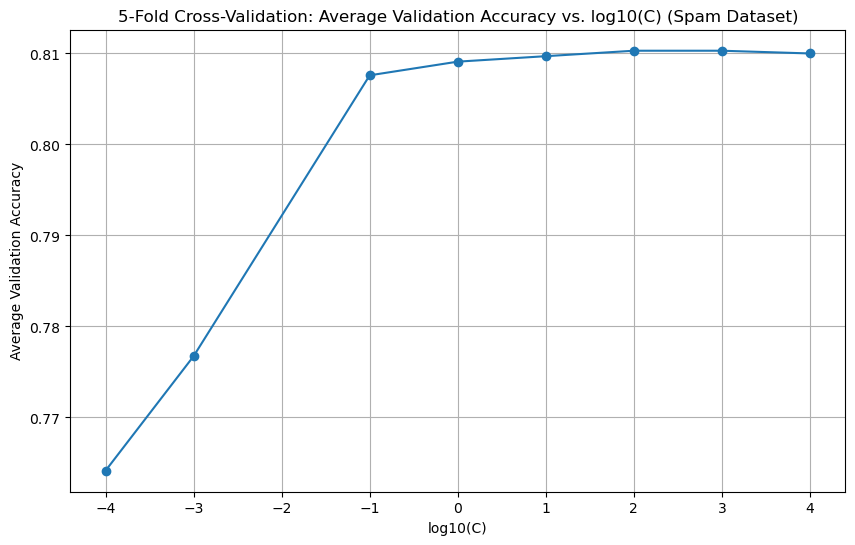

In [ ]:
def k_fold_cross_validation(train_data, train_labels, c_values, k=5):
    # Ensure the data is shuffled consistently, setting seed for reproducibility
    np.random.seed(42)
    indices = np.arange(train_data.shape[0])
    np.random.shuffle(indices)

    # Split data into k folds
    fold_size = len(indices) // k
    folds = [indices[i * fold_size: (i + 1) * fold_size] for i in range(k)]
    if len(indices) % k != 0:  # Add any remaining samples to the last fold
        folds[-1] = np.concatenate([folds[-1], indices[k * fold_size:]])

    results = []
    best_c = None
    best_avg_val_accuracy = 0

    for c in c_values:
        val_accuracies = []

        # Perform cross-validation
        for i in range(k):
            # Prepare training and validation splits
            val_indices = folds[i]
            train_indices = np.concatenate([folds[j] for j in range(k) if j != i])

            val_data = train_data[val_indices]
            val_labels = train_labels[val_indices]
            sub_train_data = train_data[train_indices]
            sub_train_labels = train_labels[train_indices]

            # Train SVM
            svm = LinearSVC(C=c, max_iter=10000, random_state=42)
            svm.fit(sub_train_data, sub_train_labels)

            # Evaluate on validation data
            val_predictions = svm.predict(val_data)
            val_accuracy = classification_accuracy(val_labels, val_predictions)
            val_accuracies.append(val_accuracy)

        # Average validation accuracy for the current C, updating C if necessary
        avg_val_accuracy = np.mean(val_accuracies)
        results.append((c, avg_val_accuracy))
        if avg_val_accuracy > best_avg_val_accuracy:
            best_c = c
            best_avg_val_accuracy = avg_val_accuracy

    return {"best_c": best_c, "best_avg_val_accuracy": best_avg_val_accuracy, "results": results}


# Define hyperparameter C values to test
c_values = [0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000]

# Perform 5-fold cross-validation on the Spam dataset
spam_cross_validation_results = k_fold_cross_validation(
    spam_train_data, spam_train_labels, c_values, k=5
)

# Output the results for Spam
print("Spam 5-Fold Cross-Validation Results:")
for c, acc in spam_cross_validation_results["results"]:
    print(f"C: {c}, Average Validation Accuracy: {acc:.4f}")
print(f"Best C: {spam_cross_validation_results['best_c']}, Best Average Validation Accuracy: {spam_cross_validation_results['best_avg_val_accuracy']:.4f}")

# Plot average validation accuracy for each C value
plt.figure(figsize=(10, 6))
c_log_values = np.log10(c_values)  # Log scale for better visualization
avg_val_accuracies = [acc for _, acc in spam_cross_validation_results["results"]]

plt.plot(c_log_values, avg_val_accuracies, marker="o")
plt.title("5-Fold Cross-Validation: Average Validation Accuracy vs. log10(C) (Spam Dataset)")
plt.xlabel("log10(C)")
plt.ylabel("Average Validation Accuracy")
plt.grid(True)
plt.show()


**Kaggle**

The cells below can be run in isolation (separate from all the above code) to reproduce my Kaggle submissions.

*MNIST Competition*

In [47]:
# Helper function to convert results to CSV
def results_to_csv(y_test, file_name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1
    df.to_csv(file_name, index_label='Id')

In [48]:
# MNIST Results

import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load the test dataset. Make sure you have CD'ed to scripts directory
data_mnist = np.load(f"../data/mnist-data.npz")
training_data_mnist = data_mnist["training_data"].reshape(-1, 28 * 28)  # Flatten images
labels_mnist = data_mnist["training_labels"]
mnist_train_data, mnist_train_labels, mnist_val_data, mnist_val_labels = shuffle_and_partition(
    training_data_mnist, labels_mnist, validation_size=10000
)

mnist_test_data = data_mnist["test_data"].reshape(-1, 28 * 28)  # Flatten images
print(mnist_test_data.shape)

# At this point, we now have: 
# mnist_train_data, mnist_train_labels, mnist_val_data, mnist_val_labels, mnist_test_data

# Standardize pixel values for better SVM performance
scaler = StandardScaler()
mnist_train_data = scaler.fit_transform(mnist_train_data)
mnist_val_data = scaler.transform(mnist_val_data)
mnist_test_data = scaler.transform(mnist_test_data)

print("Train Data Mean:", np.mean(mnist_train_data), "Std:", np.std(mnist_train_data))
print("Validation Data Mean:", np.mean(mnist_val_data), "Std:", np.std(mnist_val_data))
print("Test Data Mean:", np.mean(mnist_test_data), "Std:", np.std(mnist_test_data))

# Train an SVM model with RBF kernel
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_model.fit(mnist_train_data, mnist_train_labels)

# Evaluate on validation set
mnist_val_pred = svm_model.predict(mnist_val_data)
accuracy = accuracy_score(mnist_val_labels, mnist_val_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# Predict on test set, and convert the results to CSV
mnist_test_pred = svm_model.predict(mnist_test_data)
results_to_csv(mnist_test_pred, "mnist_predictions.csv")


(10000, 784)
Train Data Mean: -7.185182154472034e-19 Std: 0.9536449944870636
Validation Data Mean: -0.001741623368586426 Std: 0.9463424978541896
Test Data Mean: -0.00026649295210103035 Std: 0.9982727365998315
Validation Accuracy: 0.9738


*SPAM Competition*

In [49]:
# SPAM Results

# Reload datasets
data_spam = np.load(f"../data/spam-data.npz")
training_data_spam = data_spam["training_data"]
labels_spam = data_spam["training_labels"]
validation_size_spam = int(0.2 * training_data_spam.shape[0])
spam_train_data, spam_train_labels, spam_val_data, spam_val_labels = shuffle_and_partition(
    training_data_spam, labels_spam, validation_size=validation_size_spam
)
spam_test_data = data_spam["test_data"]
# At this point, we now have: 
# spam_train_data, spam_train_labels, spam_val_data, spam_val_labels, spam_test_data

spam_svm_model = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)
spam_svm_model.fit(spam_train_data, spam_train_labels)

# Evaluate on validation set
spam_val_pred = spam_svm_model.predict(spam_val_data)
accuracy = accuracy_score(spam_val_labels, spam_val_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# Predict on test set, and convert the results to CSV
spam_test_pred = spam_svm_model.predict(spam_test_data)
results_to_csv(spam_test_pred, "spam_predictions.csv")



Validation Accuracy: 0.8261
